# Import packages

In [61]:
import torch
import torch.nn as nn
import torchdiffeq
from torchdiffeq import odeint
from xitorch.interpolate import Interp1D
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt

torch.set_default_dtype(torch.float)

# Define classes for parameter-container and sequence generator

In [62]:
"""
Class RateStateParams, manages data of rate-and-state friction with flash-heating effect, contains 
    Data:
        fr: Reference friction coefficient
        a: Rate-and-state parameter a
        b: Rate-and-state parameter b
        DRS: Characteristic slip distance
        Vw: Flash-heating slip rate
        fw: Flash-heating friction coefficient
        
"""
class RateStateParams:
    # Constructor
    def __init__(self, fr = 0.6, Vr = 1.e-6, a = 0.016, b = 0.011, DRS = 1.e-6, Vw = 1.0e6, fw = 0.2):
        self.fr = fr
        self.Vr = Vr
        self.a = a
        self.b = b
        self.DRS = DRS
        self.Vw = Vw
        self.fw = fw
        
    # Output the information of this class
    def print_info(self):
        print("-" * 20, " Rate-and-state parameters ", "-"*20)
        print('fr:       ', self.fr)
        print('a:        ', self.a)
        print('b:        ', self.b)
        print('Vr:       ', self.Vr)
        print('DRS:      ', self.DRS)
        print('Vw:       ', self.Vw)
        print('fw:       ', self.fw)
        

In [63]:
"""
Class TimeSequenceGen, container for a Generated time sequence containing 
    Data:
        t [number of time points]: Tensor for time stamps, prescribed
        N [number of time points]: Tensor for normal stress, prescribed
        Ds [number of time points]: Tensor for slip rate, prescribed
        s [number of time points]: Tensor for slip, prescribed
        theta [number of hidden variables, number of time points]: Tensor for hidden variables, computed
        params : Class for parameters
   
    Method:
        __init__ : Constructor
        DthetaDt : Evolution function for hidden variables theta
        calTau : Calculate the function of shear stress Tau
        
"""
class TimeSequenceGen:
    # Constructor
    def __init__(self, t, N, Ds, params):
        # Load the parameters
        self.t = t
        self.N = N
        self.Ds = Ds
        self.s = torch.zeros(Ds.shape, dtype = torch.float64)
        self.s[:, 1:] = torch.cumulative_trapezoid(Ds, x = t)
        self.params = params
        
        # Calculate theta history
        self.theta = torch.zeros(Ds.shape, dtype = torch.float64)
        
        # Compute the interpolation for slip rate Ds
        self.t_temp = torch.concat([self.t, torch.tensor([self.t[-1] + 1.0])], 0)
        self.Ds_temp = torch.concat([self.Ds, self.Ds[:, -1].reshape([-1, 1])], 1)
        self.DsAtT = interp1d(self.t_temp, self.Ds_temp, kind="cubic")
        
        # Evolve theta(t)
        self.theta = torch.transpose(self.calTheta(), 0, 1)

        # Finish computing tau
        self.tau = self.calTau()
    
    # Function DthetaDt, defines DthetaDt as a function of temporally local values
    def DthetaDt(self, t, theta):
        # print('t = ', t)
        DthetaDt = 1. - (torch.tensor(self.DsAtT(t)) * theta / self.params.DRS)
        return DthetaDt
    
    # Function calTau, calculates shear traction tau, suingregularized rate-and-state formulation
    def calTau(self):
        # Set aliases for rate-and-state parameters
        a = self.params.a
        b = self.params.b
        Vr = self.params.Vr
        DRS = self.params.DRS
        fr = self.params.fr
        
        tau = self.N * a * torch.asinh(
                   self.Ds / 2. / Vr * torch.exp((fr + b * torch.log(Vr * self.theta / DRS)) / a)
                   )
        return tau
    
    # Calculate theta using s(t), Ds(t), theta(t) and params
    def calTheta(self, theta0 = 1.0):
        theta = odeint(self.DthetaDt, theta0 * torch.ones(self.Ds.shape[0], dtype = torch.float64), self.t, 
                       rtol = 1.e-10, atol = 1.e-12, method = 'dopri8')
        return theta


# Demo: given $N(t)$ and $V(t)$, generate $\theta(t)$ and $\tau(t)$

In [64]:
# Set parameters
myRSParams = RateStateParams()
myRSParams.print_info()

--------------------  Rate-and-state parameters  --------------------
fr:        0.6
a:         0.016
b:         0.011
Vr:        1e-06
DRS:       1e-06
Vw:        1000000.0
fw:        0.2


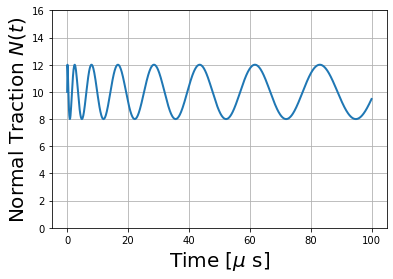

In [65]:
# Set t [s], N(t) [MPa]
t = torch.linspace(0., 100., 1000, dtype=torch.float64) * 1.0e-6
N = torch.ones(t.shape, dtype=torch.float64) * 10 + 2 * torch.sin(5 * torch.sqrt(1.e6 * t))
plt.plot(1e6 * t, N, linewidth=2.0)
plt.xlabel('Time [$\mu$ s]', fontsize=20)
plt.ylabel('Normal Traction $N(t)$', fontsize=20)
plt.ylim([0, 16])
plt.grid()
plt.show()

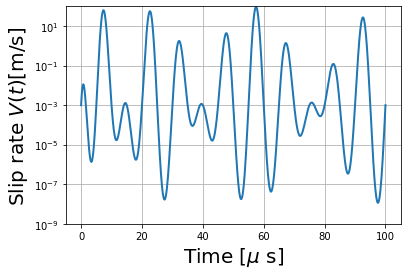

In [66]:
# Set V(t) [m/s]
T = 10. # [\mu s], minimal positive period
V = torch.pow(10., 1. + torch.ones(t.shape, dtype=torch.float64) * (-4.)  + \
              5. * torch.cos(2 * torch.pi * 0.2 * torch.sqrt(1.e6 * t)) * torch.sin(2 * torch.pi / T * 1.e6 * t))
plt.semilogy(1e6 * t, V, linewidth=2.0)
plt.xlabel('Time [$\mu$ s]', fontsize=20)
plt.ylabel('Slip rate $V(t) \mathrm{[m/s]}$', fontsize=20)
plt.ylim([1e-9, 100.])
plt.grid()
plt.show()

# Generate $\theta(t)$ and $\tau(t)$

In [67]:
# Call TimeSequenceGen
Nnew = N.reshape([1, -1]) * torch.ones([2, 1], dtype = torch.float64)
Vnew = V.reshape([1, -1]) * torch.ones([2, 1], dtype = torch.float64)
mySeq = TimeSequenceGen(t, N.reshape([1, -1]), V.reshape([1, -1]), myRSParams)
mySeqNew = TimeSequenceGen(t, Nnew, Vnew, myRSParams)

In [68]:
mySeq.tau

tensor([[7.1052, 8.6543, 8.4485, 7.9483, 7.3931, 6.8886, 6.4842, 6.1986, 6.0326,
         5.9762, 6.0131, 6.1242, 6.2896, 6.4900, 6.7078, 6.9276, 7.1368, 7.3252,
         7.4853, 7.6122, 7.7029, 7.7565, 7.7735, 7.7557, 7.7059, 7.6275, 7.5244,
         7.4007, 7.2605, 7.1080, 6.9471, 6.7815, 6.6147, 6.4497, 6.2894, 6.1362,
         5.9924, 5.8600, 5.7407, 5.6360, 5.5473, 5.4757, 5.4222, 5.3876, 5.3726,
         5.3778, 5.4035, 5.4500, 5.5172, 5.6052, 5.7134, 5.8413, 5.9883, 6.1532,
         6.3349, 6.5319, 6.7424, 6.9644, 7.1954, 7.4325, 7.6718, 7.9083, 8.1352,
         8.3433, 8.5204, 8.6506, 8.7148, 8.6917, 8.5602, 8.3037, 7.9399, 7.8504,
         7.9401, 8.0208, 8.0885, 8.1427, 8.1831, 8.2092, 8.2208, 8.2178, 8.1999,
         8.1669, 8.1186, 8.0547, 7.9753, 7.8803, 7.7704, 7.6465, 7.5098, 7.3620,
         7.2048, 7.0402, 6.8699, 6.6957, 6.5195, 6.3427, 6.1668, 5.9931, 5.8230,
         5.6573, 5.4971, 5.3433, 5.1965, 5.0573, 4.9264, 4.8040, 4.6905, 4.5862,
         4.4913, 4.4059, 4.3

In [69]:
mySeqNew.tau

tensor([[7.1052, 8.6543, 8.4485,  ..., 5.2097, 5.3466, 5.4852],
        [7.1052, 8.6543, 8.4485,  ..., 5.2097, 5.3466, 5.4852]],
       dtype=torch.float64)

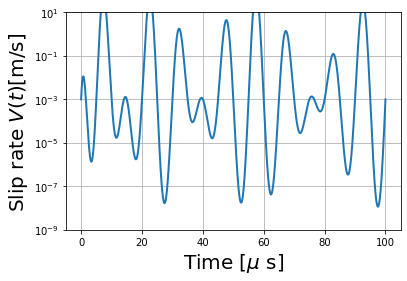

In [70]:
# Plot V(t)
plt.semilogy(1e6 * t, mySeq.Ds[0], linewidth=2.0)
plt.xlabel('Time [$\mu$ s]', fontsize=20)
plt.ylabel('Slip rate $V(t) \mathrm{[m/s]}$', fontsize=20)
plt.ylim([1e-9, 10.])
plt.grid()
plt.show()

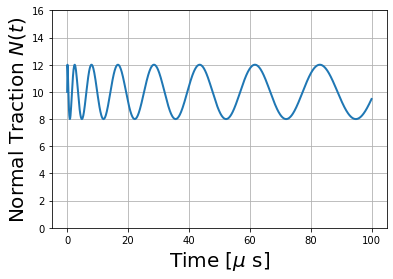

In [71]:
# Plot N(t)
plt.plot(1e6 * t, mySeq.N[0], linewidth=2.0)
plt.xlabel('Time [$\mu$ s]', fontsize=20)
plt.ylabel('Normal Traction $N(t)$', fontsize=20)
plt.ylim([0, 16])
plt.grid()
plt.show()

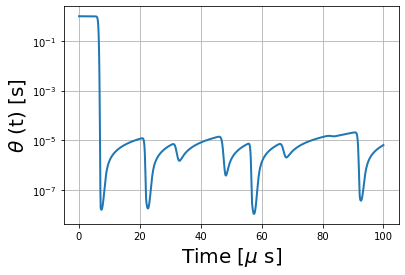

In [72]:
# Plot theta(t)
plt.semilogy(1e6 * mySeq.t, mySeq.theta[0], linewidth=2.0)
plt.xlabel('Time [$\mu$ s]', fontsize=20)
plt.ylabel('$\\theta$ (t) [s]', fontsize=20)
# plt.ylim([0, 16])
plt.grid()
plt.show()

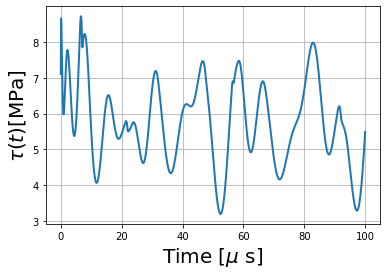

In [73]:
# Plot tau(t)
plt.plot(1e6 * mySeq.t, mySeq.tau[0], linewidth=2.0)
plt.xlabel('Time [$\mu$ s]', fontsize=20)
plt.ylabel('$\\tau(t) [\mathrm{MPa}]$', fontsize=20)
# plt.ylim([0, 16])
plt.grid()
plt.show()

# Generate training sequences in parallel

In [74]:
# Import joblibs
from joblib import Parallel, delayed, effective_n_jobs
print('Number of workers available: ', effective_n_jobs(-1))

Number of workers available:  36


In [75]:
"""
Function generateVAndN, generate V and N sequences. 
    Inputs: #-----------------------------------------------------------------------------------------
        N_seq: Number of sequences to be generated
        N_grid_points: Number of grid points in [0, T]
        n_Fourier: Number of Fourier terms in the generating functions
        T: Maximum time
        target_logV_range: The range of logV
        target_N_range: The range of normal stress
        
    Outputs: #----------------------------------------------------------------------------------------
        NAll [N_seq, N_grid_points]: Generated sample sequences of N(t)
        VAll [N_seq, N_grid_points]: Generated sample sequences of V(t)
        
"""

def generateTVAndN(N_seq = 10_000, 
                  N_grid_points = 1_000, 
                  n_Fourier = 16, 
                  T = 100.e-6, 
                  target_logV_range = [-15., 2.], 
                  target_N_range = [1., 12.]):
    
    # Generate time grid (uniform)
    t = torch.linspace(0., T, N_grid_points, dtype = torch.float64)
    
    # Pre-calculate sin(k pi/T t) and cos(k pi/T t)
    K = torch.linspace(0, n_Fourier - 1, n_Fourier, dtype = torch.float64)
    kPitOverT = K.reshape([-1, 1]) * torch.pi / T * t


    # Generate N(t) sequences in MPa, N_seq times
    NfSin = (torch.rand([N_seq, n_Fourier], dtype = torch.float64) - 0.5) * 5.
    NfCos = (torch.rand([N_seq, n_Fourier], dtype = torch.float64) - 0.5) * 5.

    # All N_seq normal tractions
    NAll = torch.matmul(NfSin, torch.sin(kPitOverT)) + torch.matmul(NfCos, torch.cos(kPitOverT))

    # Generate logV(t) sequences in m/s, N_seq times
    VfSin = (torch.rand([N_seq, n_Fourier], dtype = torch.float64) - 0.5) * 10.
    VfCos = (torch.rand([N_seq, n_Fourier], dtype = torch.float64) - 0.5) * 10.

    # All N_seq normal tractions
    VAll = torch.matmul(VfSin, torch.sin(kPitOverT)) + torch.matmul(VfCos, torch.cos(kPitOverT)) - 7.


    ## Rescale VAll, NAll into target range
    # ---------------------------------------------------------------------------------------------------------
    minVAll = torch.min(VAll, axis=1).values
    maxVAll = torch.max(VAll, axis=1).values
    VAll = VAll / (maxVAll - minVAll).reshape([-1, 1]) * (target_logV_range[1] - target_logV_range[0]) 
    # VAll -= (torch.min(VAll, axis=1).values - target_logV_range[0]).reshape([-1, 1])
    # VAll = torch.clip(VAll, min = target_logV_range[0], max = target_logV_range[1])
    print('Min, max of logV: ', torch.min(VAll).item(), torch.max(VAll).item())
    VAll = torch.pow(10., VAll)

    # NAll = torch.clip(NAll, min = target_N_range[0], max = target_N_range[1])
    minNAll = torch.min(NAll, axis=1).values
    maxNAll = torch.max(NAll, axis=1).values
    NAll = NAll / (maxNAll - minNAll).reshape([-1, 1]) * (target_N_range[1] - target_N_range[0]) 
    NAll -= (torch.min(NAll, axis=1).values - target_N_range[0]).reshape([-1, 1])

    print('Min, max of N: ', torch.min(NAll).item(), torch.max(NAll).item())

    return t, NAll, VAll

In [210]:
import time
# Generate the sequences
filename = "./data/sequence3.pt"
N_samples = 10_000
N_gridPts = 1_000

t, NAll, VAll = generateTVAndN(N_seq = N_samples, N_grid_points = N_gridPts)
RSparams = RateStateParams()
RSparams.print_info()

# Define the function to run in parallel
def getSTauAndTheta(t, N, V, params):
    mySeq = TimeSequenceGen(t, N, V, params)
    return mySeq.s, mySeq.tau, mySeq.theta

# Compute tau and theta
st_time = time.time()
sAll, tauAll, thetaAll = getSTauAndTheta(t, NAll, VAll, RSparams)
timeConsumed = time.time() - st_time
print('Time consumed (single core): ', timeConsumed, ' s')

# Save to file
seqObj = {'S' : sAll, 'N' : NAll, 'V' : VAll, 'tau' : tauAll, 'theta' : thetaAll, 't' : t}
torch.save(seqObj, filename)

Min, max of logV:  -15.0 2.0
Min, max of N:  0.9999999999999991 12.000000000000004
--------------------  Rate-and-state parameters  --------------------
fr:        0.6
a:         0.016
b:         0.011
Vr:        1e-06
DRS:       1e-06
Vw:        1000000.0
fw:        0.2
Time consumed (single core):  431.0603802204132  s


In [76]:
# Load from file
filename = "./data/sequence3.pt"
loaded = torch.load(filename)
tauAll = loaded['tau']
NAll = loaded['N']
VAll = loaded['V']
sAll = loaded['S']
thetaAll = loaded['theta']
t = loaded['t']

RSparams = RateStateParams()

Text(0.5, 0.98, 'The 5000th sequence')

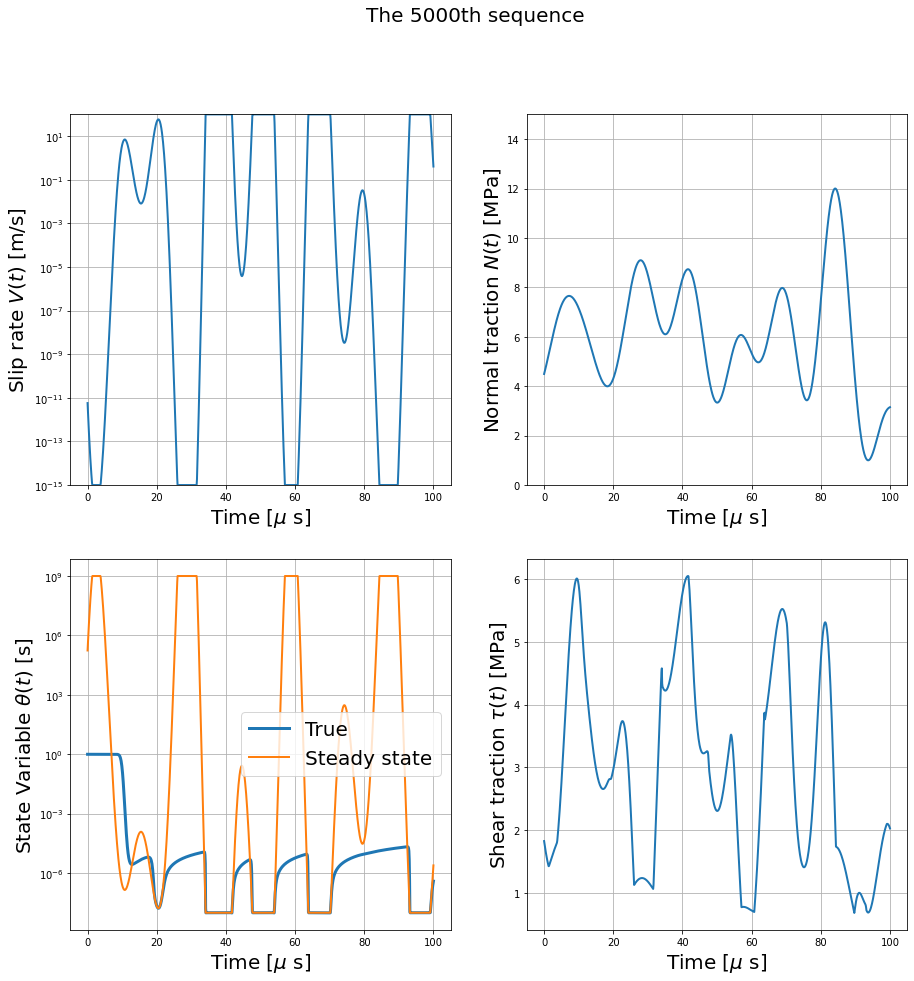

In [77]:
# Plot Sequence of V(t) and N(t) given sample-index
sample_idx = 5000
f, axs = plt.subplots(2, 2, figsize = (15, 15))

# Plot V(t)
axs[0][0].semilogy(1e6 * t, VAll[sample_idx, :], linewidth=2.0)
axs[0][0].set_xlabel('Time [$\mu$ s]', fontsize=20)
axs[0][0].set_ylabel('Slip rate $V(t)\  \mathrm{[m/s]}$', fontsize=20)
axs[0][0].set_ylim([1e-15, 1e2])
axs[0][0].grid()

# Plot N(t)
axs[0][1].plot(1e6 * t, NAll[sample_idx, :], linewidth=2.0)
axs[0][1].set_xlabel('Time [$\mu$ s]', fontsize=20)
axs[0][1].set_ylabel('Normal traction $N(t)\ \mathrm{[MPa]}$', fontsize=20)
axs[0][1].set_ylim([0, 15])
axs[0][1].grid()
                
# Plot theta(t)
axs[1][0].semilogy(1e6 * t, thetaAll[sample_idx, :], linewidth=3.0)
axs[1][0].semilogy(1e6 * t, RSparams.DRS / VAll[sample_idx, :], linewidth=2.0)
axs[1][0].set_xlabel('Time [$\mu$ s]', fontsize=20)
axs[1][0].set_ylabel('State Variable $\\theta(t)\ \mathrm{[s]}$', fontsize=20)
axs[1][0].legend(['True', 'Steady state'], loc='best', fontsize=20)
axs[1][0].grid()
                
# Plot \tau(t)
axs[1][1].plot(1e6 * t, tauAll[sample_idx, :], linewidth=2.0)
axs[1][1].set_xlabel('Time [$\mu$ s]', fontsize=20)
axs[1][1].set_ylabel('Shear traction $\\tau(t)\ \mathrm{[MPa]}$', fontsize=20)
axs[1][1].grid()

f.suptitle("The " + str(sample_idx) + "th sequence", fontsize = 20)

# RNN for training

In [78]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


In [79]:
"""
Class RSRNN: Maps from X(t) = (N(t), V(t), S(t)) to tau(t)
   
"""
class RSRNN(nn.Module):
    
    # Constructor
    def __init__(self, input_size = 3, output_size = 1, hidden_dim = 1, n_layers = 1, isGRU = False):
        r"""
            Inputs: #-----------------------------------------------------------------------------------------
                input_size: dimension of input X(t)
                output_size: dimension of output tau(t)
                hidden_dim: dimension of hidden variables xi(t)
                n_layers: number of stacked RNN layers
        
        """
        
        # Call parent class constructor
        super(RSRNN, self).__init__()
        
        # Defining some parameters
        self.input_size = input_size
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        #Defining the layers
        # RNN Layer
        self.rnn = nn.RNN(input_size = self.input_size, 
                          hidden_size = self.hidden_dim, 
                          num_layers = n_layers, 
                          batch_first = True)
        if isGRU:
            self.rnn = nn.GRU(input_size = self.input_size, 
                              hidden_size = self.hidden_dim, 
                              num_layers = n_layers, 
                              batch_first = True)
        
        # Fully connected layers, maps from (X(t), xi(t)) to tau(t)
        self.fc = nn.Sequential(
            nn.Linear(input_size + hidden_dim, 64), 
            nn.ReLU(), 
            nn.Linear(64, 64), 
            nn.ReLU(), 
            nn.Linear(64, output_size),
        )
    
    
    # Forward evaluation function
    def forward(self, x):
        r"""
            Inputs: #-----------------------------------------------------------------------------------------
                x [batch_size, sequence_length, input_size]: A batch of input sequences X([0, t])

            Outputs: #----------------------------------------------------------------------------------------
                out [batch_size, sequence_length, output_size]: The batch of output sequences tau([0, t])
                Hs [batch_size, sequence_length, hidden_dim]: The batch of hidden variables xi([0, t]), 
                    only on the last layer if n_layers is greater than 1.
            
        """
        # Get the batch_size, x is organized as [batch_size, sequence_length, input_size]
        batch_size = x.size(0)

        # Initializing hidden state for first input using method defined below
        hidden = self.init_hidden(batch_size)

        # Passing in the input and hidden state into the model and obtaining outputs
        Hs, hidden = self.rnn(x, hidden)
        
        # Reshaping the outputs such that it can be fit into the fully connected layer
        xAndH = torch.cat([x, Hs], 2)
        # xAndH_newView = xAndH.contiguous().view(-1, self.hidden_dim + self.input_size)
        
        # Get the output from (x, H)
        out = self.fc(xAndH)
        
        return out, Hs
    
    
    # Initialize the hidden variables xi(0)
    def init_hidden(self, batch_size):
        r"""
            Inputs: #-----------------------------------------------------------------------------------------
                batch_size
                
            Outputs: #-----------------------------------------------------------------------------------------
                hidden [n_layers, batch_size, hidden_dim]: Initialized hidden 
        """
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        # We'll send the tensor holding the hidden state to the device we specified earlier as well
        hidden = torch.ones([self.n_layers, batch_size, self.hidden_dim])
        return hidden

# Define loss functions

In [80]:
"""
Function AccessibleL2Loss, Calculate L2 loss in time for a sequence
    Inputs: #-----------------------------------------------------------------------------------------
        X [batch_size, n_grid_points]: A batch of predicted sequences
        X_true [batch_size, n_grid_points]: The batch of real sequences
        
    Outputs: #----------------------------------------------------------------------------------------
        L2Loss: |X - X_true|^2
        
"""
def AccessibleL2Loss(X, X_true, normalize = True):
    L2Loss = torch.sum(torch.square(X - X_true)) / X.shape[0]
    if normalize:
        L2Loss = L2Loss / X.shape[1]
    return torch.sqrt(L2Loss)


# Set up a training example

In [117]:
# Dataloader
from torch.utils.data import TensorDataset, DataLoader
logVFlag = True

# Data set contains ([N(t), V(t), S(t)]; [theta(t), tau(t)])
XAll = torch.stack([NAll, VAll, sAll], 2)

# Turn input into logV
if logVFlag:
    XAll = torch.stack([NAll, torch.log10(VAll), sAll], 2)

print('XAll shape: ', XAll.shape)

AllData = TensorDataset(
    XAll.float(),
    thetaAll.reshape([thetaAll.shape[0], thetaAll.shape[1], 1]).float(),
    tauAll.reshape([thetaAll.shape[0], thetaAll.shape[1], 1]).float(),
)

# Training-testing separation
trainSetLen = int(len(AllData) * 0.8)
testSetLen = len(AllData) - trainSetLen

# Train on multiplied data set
XAll_train = XAll[0 : trainSetLen]
thetaAll_train = thetaAll[0 : trainSetLen]
tauAll_train = tauAll[0 : trainSetLen]

NByN0 = [0.25, 0.5, 1., 2., 4.]
XAll_train = torch.cat([XAll_train * torch.tensor([[[x, 1., 1.]]]) for x in NByN0], 0)
thetaAll_train = torch.cat([thetaAll_train for i in range(len(NByN0))], 0)
tauAll_train = torch.cat([tauAll_train * torch.tensor(x) for x in NByN0], 0)

training_indexes = torch.randperm(XAll_train.shape[0])
XAll_train = XAll_train[training_indexes]
thetaAll_train = thetaAll_train[training_indexes]
tauAll_train = tauAll_train[training_indexes]

trainDataSet = TensorDataset(
    XAll_train.float(), 
    thetaAll_train.reshape([thetaAll_train.shape[0], thetaAll_train.shape[1], 1]),
    tauAll_train.reshape([thetaAll_train.shape[0], thetaAll_train.shape[1], 1])
)

# Separate the data set
# trainDataSet, testDataSet = torch.utils.data.random_split(AllData, [trainSetLen, testSetLen])
# trainDataSet = torch.utils.data.Subset(AllData, range(0, trainSetLen))
testDataSet = torch.utils.data.Subset(AllData, range(trainSetLen, testSetLen + trainSetLen))
print('Training data set length: ', len(trainDataSet))
print('Testing data set length: ', len(testDataSet))

# Training data loader
training_batch_size = 1024
trainDataLoader = DataLoader(
    trainDataSet,
    batch_size = training_batch_size,
    shuffle = True,
#    num_workers = 16,
    collate_fn = None,
    pin_memory = False,
)

# Testing data loader
testing_batch_size = 256
testDataLoader = DataLoader(
    testDataSet,
    batch_size = testing_batch_size,
    shuffle = True,
#    num_workers = 16,
    collate_fn = None,
    pin_memory = False,
)

XAll shape:  torch.Size([10000, 1000, 3])
Training data set length:  40000
Testing data set length:  2000


In [118]:
# Function train1Epoch
def train1Epoch(dataloader, loss_fn, model, optimizer):
    r"""
        Inputs: # --------------------------------------------------------------------------------------------
            dataloader: training data set loader
            loss_fn: loss function
            model: the RNN model being trained
            optimizer: handle to the optimizer
            NMultiFlag: if or not to duplicate the sequences by multiply N(t) with a constant
        Outputs: # -------------------------------------------------------------------------------------------
            loss: Training loss at the current data set
    
    """
    losses = []
    # multis = [1., 2., 4., 8., 16.]
    for idx, (X, theta, tau) in enumerate(dataloader):
        # Arrangement of X [N, logV, s]
#         # DEBUG LINES
#         print('X shape: ', X.shape)
#         print('theta shape: ', theta.shape)
#         print('tau shape: ', tau.shape)
        # XMulti = torch.cat([X * torch.tensor([[[x, 1., 1.]]]) for x in multis], 0)
        # tauMulti = torch.cat([tau * torch.tensor([[[x]]]) for x in multis], 0)
        optimizer.zero_grad()
        # out, Hs = model(XMulti)
        # loss = loss_fn(tauMulti, out)
        out, Hs = model(X)
        loss = loss_fn(tau, out)
        
#         # DEBUG LINES
#         print('loss of batch ', idx, ': ', loss)
        
        loss.backward()
        optimizer.step()
        losses.append(loss * X.shape[0])
    
    # Return the avg loss for each sequence
    return sum(losses) / len(dataloader.dataset)


# Function evaluate test loss
def evaluateTestLoss(dataloader, loss_fn, model):
    r"""
        Inputs: # --------------------------------------------------------------------------------------------
            dataloader: testing data set loader
            loss_fn: loss function
            model: the RNN model being trained
            
        Outputs: # -------------------------------------------------------------------------------------------
            loss: Testing loss at the current data set
    
    """
    losses = []
    for idx, (X, theta, tau) in enumerate(dataloader):
        out, Hs = model(X)
        loss = loss_fn(tau, out)
        losses.append(loss * X.shape[0])
    
    # Return the avg loss for each sequence
    return sum(losses) / len(dataloader.dataset)

In [119]:
import time
# Train for 100 epochs
model_save_path = './data/model_synData_1018_seq3_hiddenDim1_NMulti.pth'
loss_save_path = './data/loss_synData_1018_seq3_hiddenDim1_NMulti.pt'
loss_history_train = []
loss_history_test = []

# Number of epochs
n_epochs = 100
output_freq = 1

# Initialize the RNN 
# model = RSRNN(n_layers=1, isGRU = False)

# Learning rate
learning_rate = 1.0e-3

# Optimizer SGD
import torch.optim as optim
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)


for epoch in range(n_epochs):
    st_time = time.time()
    
    # Train for 1 epoch
    train_loss = train1Epoch(trainDataLoader, AccessibleL2Loss, model, optimizer)
    loss_history_train.append(train_loss.item())
    
    # Track training time
    epoch_time = time.time() - st_time
    
    # Evaluate test loss
    test_loss = evaluateTestLoss(testDataLoader, AccessibleL2Loss, model)
    loss_history_test.append(test_loss.item())
    
    # Print out information
    if epoch % output_freq == 0:
        print("-"*20, " Epoch ", epoch, "-"*20)
        print("Training loss: ", train_loss)
        print("Testing loss: ", test_loss)
        print("Training time for this epoch: ", epoch_time)
        print('\n')

# Save the trained model
LossObj = {'train_loss' : loss_history_train, 'test_loss' : loss_history_test}
torch.save(model, model_save_path)
torch.save(LossObj, loss_save_path)


--------------------  Epoch  0 --------------------
Training loss:  tensor(1.2716, dtype=torch.float64, grad_fn=<DivBackward0>)
Testing loss:  tensor(0.6550, grad_fn=<DivBackward0>)
Training time for this epoch:  27.22922372817993


--------------------  Epoch  1 --------------------
Training loss:  tensor(0.9199, dtype=torch.float64, grad_fn=<DivBackward0>)
Testing loss:  tensor(0.5144, grad_fn=<DivBackward0>)
Training time for this epoch:  27.102232694625854


--------------------  Epoch  2 --------------------
Training loss:  tensor(0.8606, dtype=torch.float64, grad_fn=<DivBackward0>)
Testing loss:  tensor(0.4706, grad_fn=<DivBackward0>)
Training time for this epoch:  27.880963563919067


--------------------  Epoch  3 --------------------
Training loss:  tensor(0.8352, dtype=torch.float64, grad_fn=<DivBackward0>)
Testing loss:  tensor(0.4593, grad_fn=<DivBackward0>)
Training time for this epoch:  26.109631061553955


--------------------  Epoch  4 --------------------
Training loss

--------------------  Epoch  35 --------------------
Training loss:  tensor(0.6456, dtype=torch.float64, grad_fn=<DivBackward0>)
Testing loss:  tensor(0.3236, grad_fn=<DivBackward0>)
Training time for this epoch:  25.68332839012146


--------------------  Epoch  36 --------------------
Training loss:  tensor(0.6437, dtype=torch.float64, grad_fn=<DivBackward0>)
Testing loss:  tensor(0.3248, grad_fn=<DivBackward0>)
Training time for this epoch:  26.227977991104126


--------------------  Epoch  37 --------------------
Training loss:  tensor(0.6464, dtype=torch.float64, grad_fn=<DivBackward0>)
Testing loss:  tensor(0.3266, grad_fn=<DivBackward0>)
Training time for this epoch:  25.49485683441162


--------------------  Epoch  38 --------------------
Training loss:  tensor(0.6429, dtype=torch.float64, grad_fn=<DivBackward0>)
Testing loss:  tensor(0.3227, grad_fn=<DivBackward0>)
Training time for this epoch:  26.775251865386963


--------------------  Epoch  39 --------------------
Training 

--------------------  Epoch  70 --------------------
Training loss:  tensor(0.6423, dtype=torch.float64, grad_fn=<DivBackward0>)
Testing loss:  tensor(0.3177, grad_fn=<DivBackward0>)
Training time for this epoch:  26.55246877670288


--------------------  Epoch  71 --------------------
Training loss:  tensor(0.6360, dtype=torch.float64, grad_fn=<DivBackward0>)
Testing loss:  tensor(0.3163, grad_fn=<DivBackward0>)
Training time for this epoch:  25.664278507232666


--------------------  Epoch  72 --------------------
Training loss:  tensor(0.6419, dtype=torch.float64, grad_fn=<DivBackward0>)
Testing loss:  tensor(0.3163, grad_fn=<DivBackward0>)
Training time for this epoch:  26.667337894439697


--------------------  Epoch  73 --------------------
Training loss:  tensor(0.6383, dtype=torch.float64, grad_fn=<DivBackward0>)
Testing loss:  tensor(0.3644, grad_fn=<DivBackward0>)
Training time for this epoch:  26.041242122650146


--------------------  Epoch  74 --------------------
Training

# Load model, plot predictions

Text(0.5, 1.0, 'Training with 1 hidden variable')

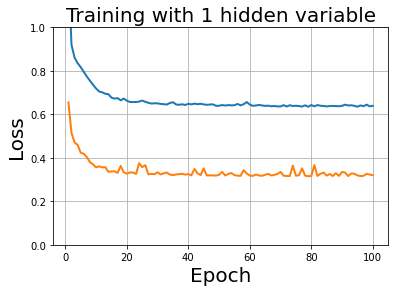

In [120]:
# Paths
model_save_path = './data/model_synData_1018_seq3_hiddenDim1_NMulti.pth'
loss_save_path = './data/loss_synData_1018_seq3_hiddenDim1_NMulti.pt'
trainedModel = torch.load(model_save_path)
loadedHistory = torch.load(loss_save_path)

loss_history_train = loadedHistory['train_loss']
loss_history_test = loadedHistory['test_loss']

# Plot loss-epoch curve
plt.plot(range(1, 1 + len(loss_history_train)), loss_history_train, linewidth = 2.0)
plt.plot(range(1, 1 + len(loss_history_test)), loss_history_test, linewidth = 2.0)
plt.grid()

plt.xlabel('Epoch', fontsize = 20)
plt.ylabel('Loss', fontsize = 20)
plt.ylim([0, 1])
plt.title('Training with 1 hidden variable', fontsize = 20)


Text(0.5, 0.98, 'The 3th sequence')

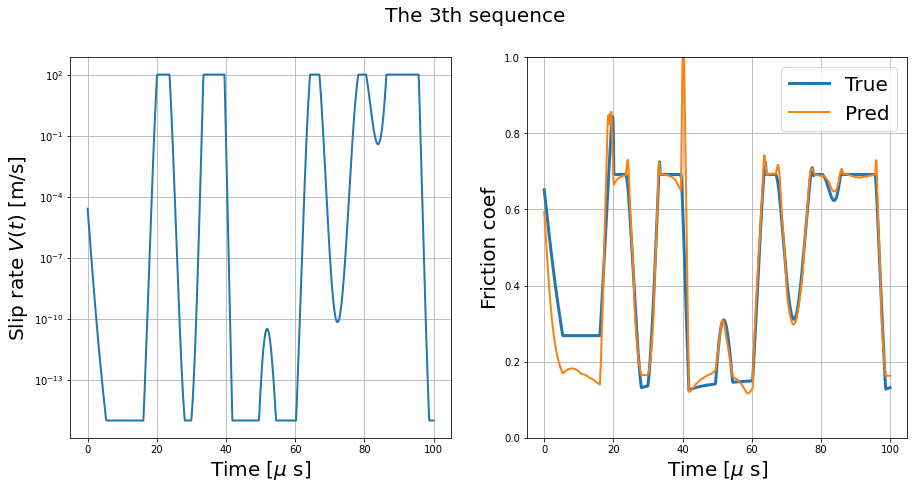

In [146]:
# Plot the slip rate, friction coefficient vs. time for sequence [idx]
idx = 3
f, axs = plt.subplots(1, 2, figsize = (15, 7))
XAll_test = XAll[testDataSet.indices].float()
VAll_test = VAll[testDataSet.indices].float()
thetaAll_test = thetaAll[testDataSet.indices].float()
NAll_test = NAll[testDataSet.indices].float()
sAll_test = sAll[testDataSet.indices].float()
tauAll_test_true = tauAll[testDataSet.indices].float()

# XAll_test = XAll[testDataSet.indices]
# VAll_test = VAll[testDataSet.indices]
# thetaAll_test = thetaAll[testDataSet.indices]
# NAll_test = NAll[testDataSet.indices]
# sAll_test = sAll[testDataSet.indices]
# tauAll_test_true = tauAll[testDataSet.indices]

tauAll_test_pred, hiddenAll_test_pred = trainedModel(XAll_test)
tauAll_test_pred = tauAll_test_pred.reshape([tauAll_test_pred.shape[0], XAll_test.shape[1]]).detach()
fcoef_test_true = tauAll_test_true / NAll_test
fcoef_test_pred = tauAll_test_pred / NAll_test

# Plot V(t)
axs[0].semilogy(1e6 * t, VAll_test[idx, :], linewidth=2.0)
axs[0].set_xlabel('Time [$\mu$ s]', fontsize=20)
axs[0].set_ylabel('Slip rate $V(t)\  \mathrm{[m/s]}$', fontsize=20)
# axs[0].set_ylim([1e-6, 1e2])
axs[0].grid()
                
# Plot fcoef(t)
# axs[1].scatter(1e6 * t, fcoef_test_true[idx, :])
axs[1].plot(1e6 * t, fcoef_test_true[idx, :], linewidth=3.0)
axs[1].plot(1e6 * t, fcoef_test_pred[idx, :], linewidth=2.0)
axs[1].legend(['True', 'Pred'], loc = 'best', fontsize = 20)
axs[1].set_xlabel('Time [$\mu$ s]', fontsize=20)
axs[1].set_ylabel('Friction coef', fontsize=20)
axs[1].set_ylim([0, 1])
axs[1].grid()

f.suptitle("The " + str(idx) + "th sequence", fontsize = 20)

Text(0.5, 0.98, 'The 1000th sequence')

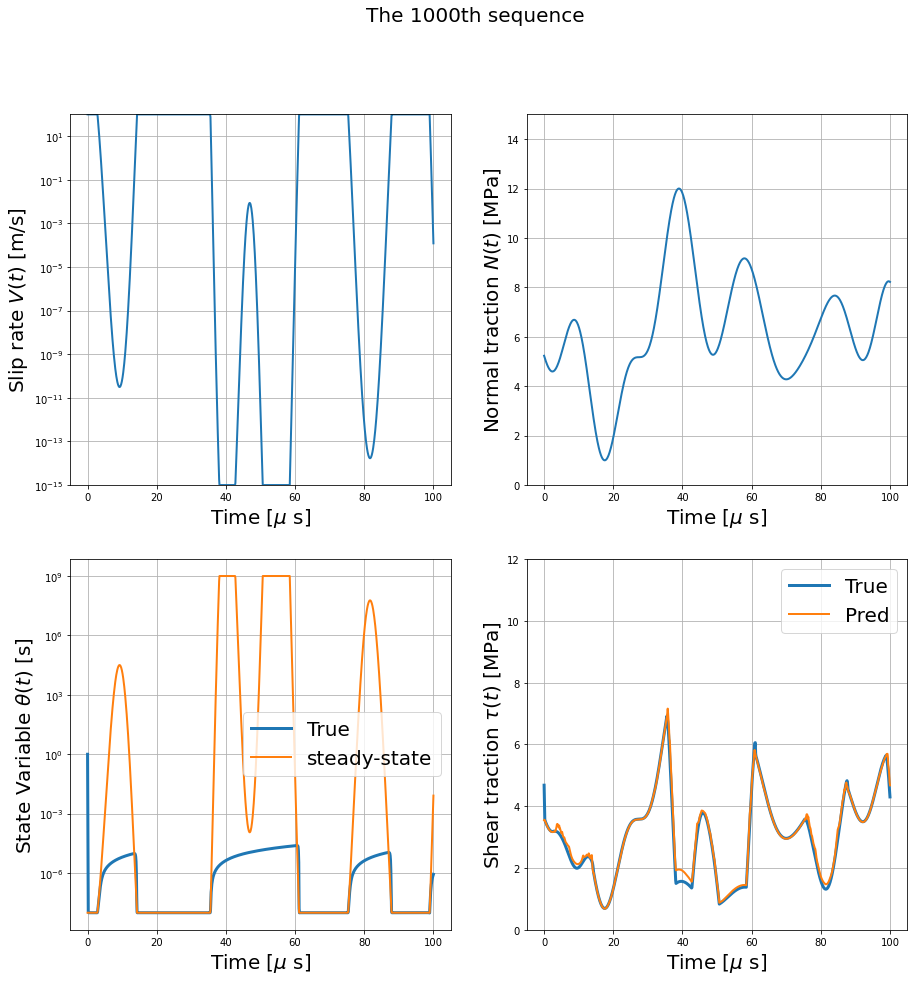

In [122]:
# Plot the V(t), N(t), theta(t), tau(t) for sequence [idx]
f, axs = plt.subplots(2, 2, figsize = (15, 15))

# Plot V(t)
axs[0][0].semilogy(1e6 * t, VAll_test[idx, :], linewidth=2.0)
axs[0][0].set_xlabel('Time [$\mu$ s]', fontsize=20)
axs[0][0].set_ylabel('Slip rate $V(t)\  \mathrm{[m/s]}$', fontsize=20)
axs[0][0].set_ylim([1e-15, 1e2])
axs[0][0].grid()

# Plot N(t)
axs[0][1].plot(1e6 * t, NAll_test[idx, :], linewidth=2.0)
axs[0][1].set_xlabel('Time [$\mu$ s]', fontsize=20)
axs[0][1].set_ylabel('Normal traction $N(t)\ \mathrm{[MPa]}$', fontsize=20)
axs[0][1].set_ylim([0, 15])
axs[0][1].grid()
                
# Plot theta(t)
axs[1][0].semilogy(1e6 * t, thetaAll_test[idx, :], linewidth=3.0)
axs[1][0].semilogy(1e6 * t, 1.e-6 / VAll_test[idx, :], linewidth=2.0)
axs[1][0].legend(['True', 'steady-state'], loc='best', fontsize = 20)
axs[1][0].set_xlabel('Time [$\mu$ s]', fontsize=20)
axs[1][0].set_ylabel('State Variable $\\theta(t)\ \mathrm{[s]}$', fontsize=20)
axs[1][0].grid()
                
# Plot \tau(t)
axs[1][1].plot(1e6 * t, tauAll_test_true[idx, :], linewidth=3.0)
axs[1][1].plot(1e6 * t, tauAll_test_pred[idx, :], linewidth=2.0)
axs[1][1].legend(['True', 'Pred'], loc = 'best', fontsize = 20)
axs[1][1].set_xlabel('Time [$\mu$ s]', fontsize=20)
axs[1][1].set_ylabel('Shear traction $\\tau(t)\ \mathrm{[MPa]}$', fontsize=20)
axs[1][1].set_ylim([0, 12])
axs[1][1].grid()

f.suptitle("The " + str(idx) + "th sequence", fontsize = 20)

# Test on a real slip-rate-sequence obtained from FEM simulation

In [127]:
# Load from file
filename = "./data/realDatas1018.pt"
loaded = torch.load(filename)
indexes = loaded['indexes']
tauReal = loaded['tau'][indexes]
NrealTest = loaded['N'][indexes]
VrealTest = loaded['V'][indexes]
sReal = loaded['S'][indexes]
thetaReal = loaded['theta'][indexes]
t = loaded['t']


print('-' * 20, 'Data Info', '-' * 20)
print('Number of data lines: ', NrealTest.shape[0])
print('Number of time grid points: ', NrealTest.shape[1])

-------------------- Data Info --------------------
Number of data lines:  18685
Number of time grid points:  1000


In [128]:
# Get RNN prediction from trained model on the same test data set
model_save_path = './data/model_synData_1018_seq3_hiddenDim1.pth'
trainedModel = torch.load(model_save_path)
XReal = torch.stack([NrealTest, torch.log10(VrealTest), sReal], 2).float()
tauReal_pred, hiddenReal_pred = trainedModel(XReal)
tauReal_pred = tauReal_pred.reshape([tauReal_pred.shape[0], tauReal_pred.shape[1]]).detach()
testSt = 14948


# Performance on real data sets:

Text(0.5, 0.98, 'The 14949th sequence')

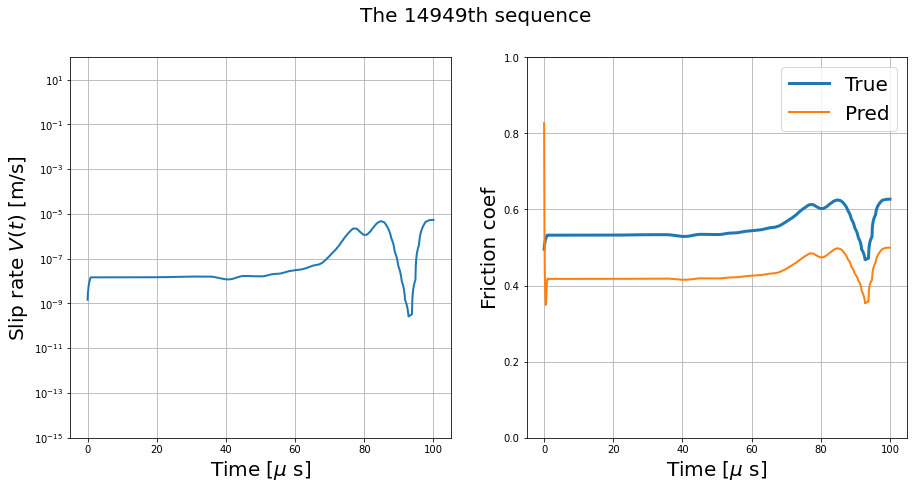

In [131]:
# Plot the slip rate, friction coefficient vs. time for sequence [idx]
idx = 1 + testSt
f, axs = plt.subplots(1, 2, figsize = (15, 7))

# Plot V(t)
axs[0].semilogy(1e6 * t, VrealTest[idx, :], linewidth=2.0)
axs[0].set_xlabel('Time [$\mu$ s]', fontsize=20)
axs[0].set_ylabel('Slip rate $V(t)\  \mathrm{[m/s]}$', fontsize=20)
axs[0].set_ylim([1e-15, 1e2])
axs[0].grid()

fcoef_real_true = tauReal / NrealTest
fcoef_real_pred = tauReal_pred / NrealTest
                
# Plot fcoef(t)
axs[1].plot(1e6 * t, fcoef_real_true[idx, :], linewidth=3.0)
axs[1].plot(1e6 * t, fcoef_real_pred[idx, :], linewidth=2.0)
axs[1].legend(['True', 'Pred'], loc = 'best', fontsize = 20)
axs[1].set_xlabel('Time [$\mu$ s]', fontsize=20)
axs[1].set_ylabel('Friction coef', fontsize=20)
axs[1].set_ylim([0, 1])
axs[1].grid()

f.suptitle("The " + str(idx) + "th sequence", fontsize = 20)

Text(0.5, 0.98, 'The 14948th sequence')

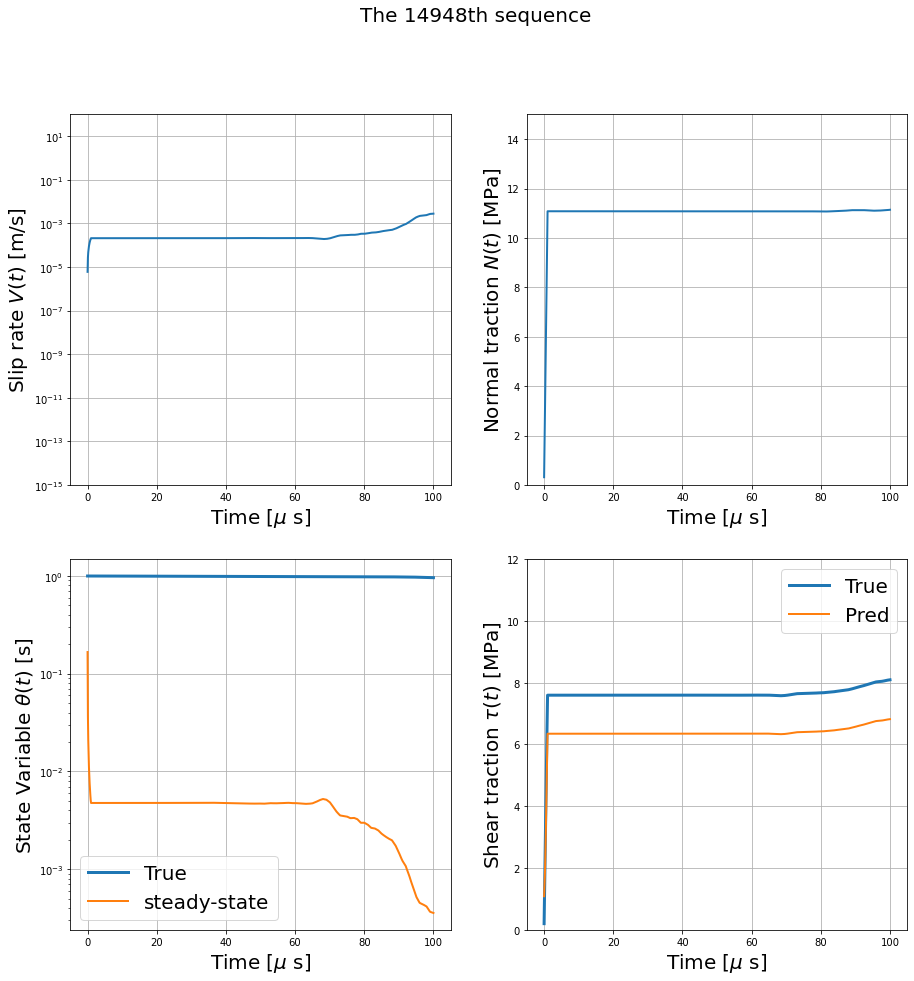

In [132]:
# Plot the V(t), N(t), theta(t), tau(t) for sequence [idx]
idx = 0 + testSt
f, axs = plt.subplots(2, 2, figsize = (15, 15))

# Plot V(t)
axs[0][0].semilogy(1e6 * t, VrealTest[idx, :], linewidth=2.0)
axs[0][0].set_xlabel('Time [$\mu$ s]', fontsize=20)
axs[0][0].set_ylabel('Slip rate $V(t)\  \mathrm{[m/s]}$', fontsize=20)
axs[0][0].set_ylim([1e-15, 1e2])
axs[0][0].grid()

# Plot N(t)
axs[0][1].plot(1e6 * t, NrealTest[idx, :], linewidth=2.0)
axs[0][1].set_xlabel('Time [$\mu$ s]', fontsize=20)
axs[0][1].set_ylabel('Normal traction $N(t)\ \mathrm{[MPa]}$', fontsize=20)
axs[0][1].set_ylim([0, 15])
axs[0][1].grid()
                
# Plot theta(t)
axs[1][0].semilogy(1e6 * t, thetaReal[idx, :], linewidth=3.0)
axs[1][0].semilogy(1e6 * t, 1.e-6 / VrealTest[idx, :], linewidth=2.0)
axs[1][0].legend(['True', 'steady-state'], loc='best', fontsize = 20)
axs[1][0].set_xlabel('Time [$\mu$ s]', fontsize=20)
axs[1][0].set_ylabel('State Variable $\\theta(t)\ \mathrm{[s]}$', fontsize=20)
axs[1][0].grid()
                
# Plot \tau(t)
axs[1][1].plot(1e6 * t, tauReal[idx, :], linewidth=3.0)
axs[1][1].plot(1e6 * t, tauReal_pred[idx, :], linewidth=2.0)
axs[1][1].legend(['True', 'Pred'], loc = 'best', fontsize = 20)
axs[1][1].set_xlabel('Time [$\mu$ s]', fontsize=20)
axs[1][1].set_ylabel('Shear traction $\\tau(t)\ \mathrm{[MPa]}$', fontsize=20)
axs[1][1].set_ylim([0, 12])
axs[1][1].grid()

f.suptitle("The " + str(idx) + "th sequence", fontsize = 20)

# Test whether $\tau(t)$ is proportional to $N(t)$, on SYNTHETIC data set

In [152]:
# Specify the index in the test data set to start from
idx = 100

# XAll test is organized as [N, logV, Slip]
X = XAll_test[idx, :, :]
nOfTimeSteps = X.shape[0]
nOfFeatures = X.shape[1]

# Multplications on N
multis = torch.tensor([0.25, 0.5, 1.0, 2.0, 4.0]).reshape([-1, 1])
multis = torch.cat([multis, torch.ones([multis.shape[0], 1]), torch.ones([multis.shape[0], 1])], 1)
multis = multis.reshape([multis.shape[0], 1, multis.shape[1]])
multis = multis.expand([-1, nOfTimeSteps, -1])
X = X.reshape([1, X.shape[0], X.shape[1]])
X = X * multis

# Make predictions
NX = X[:, :, 0]
tauX, hiddenX = trainedModel(X)
tauX = tauX.reshape([tauX.shape[0], tauX.shape[1]])

Text(0.5, 0.98, 'The 100th sequence')

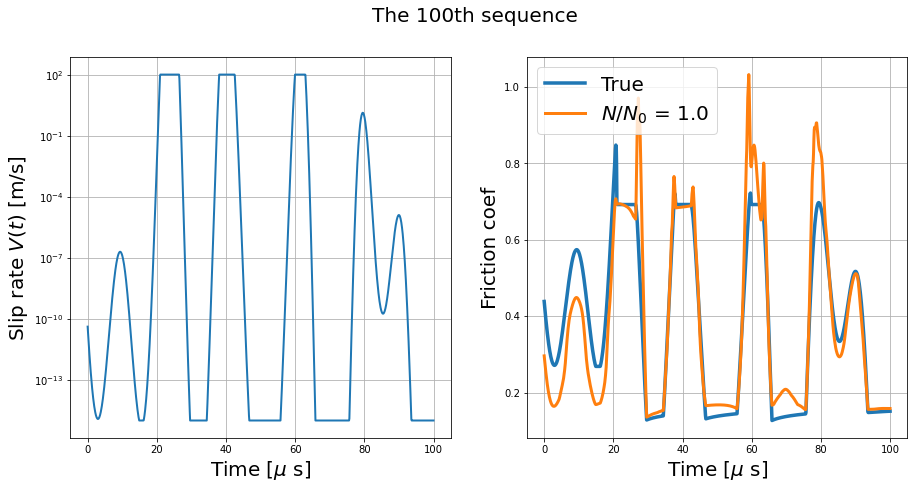

In [153]:
# Plot friction coefficient vs. time for different N/N_0
NByN0 = [3]
# NByN0 = [1]
# Plot the slip rate, friction coefficient vs. time for sequence [idx]
f, axs = plt.subplots(1, 2, figsize = (15, 7))

# Find the friction coefficient
tauXidxs = [x - 1 for x in NByN0]
fric_multis = tauX[tauXidxs] / NX[tauXidxs]
fric_multis = fric_multis.detach()

# Plot V(t)
axs[0].semilogy(1e6 * t, VAll_test[idx, :], linewidth=2.0)
axs[0].set_xlabel('Time [$\mu$ s]', fontsize=20)
axs[0].set_ylabel('Slip rate $V(t)\  \mathrm{[m/s]}$', fontsize=20)
# axs[0].set_ylim([1e-6, 1e2])
axs[0].grid()
                
# Plot the true values of fcoef(t)
# axs[1].scatter(1e6 * t, fcoef_test_true[idx, :])
axs[1].plot(1e6 * t, fcoef_test_true[idx, :], linewidth = 3.5)
lineWidths = torch.linspace(3.0, 1.0, len(NByN0))
legStr = ["True"]

for i in range(len(NByN0)):
    axs[1].plot(1e6 * t, fric_multis[i, :], linewidth = lineWidths[i])
    legStr.append("$N / N_0$ = " + str(multis[tauXidxs[i], 0, 0].item()))
    

axs[1].legend(legStr, loc = 'best', fontsize = 20)
axs[1].set_xlabel('Time [$\mu$ s]', fontsize=20)
axs[1].set_ylabel('Friction coef', fontsize=20)
# axs[1].set_ylim([0, 1])
axs[1].grid()

f.suptitle("The " + str(idx) + "th sequence", fontsize = 20)